In [12]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
%matplotlib widget

In [13]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)

In [14]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color='blue', alpha=0.5))

In [15]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [16]:
initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, {"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
a = EstimationAgent(0.1, 0.2, 10.0/180*math.pi, estimator)
estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)

for p in estimator.particles:
    print(p.pose)

[0.02555894 0.00021427 0.01676596]
[2.19787764e-02 8.19047417e-05 7.45304117e-03]
[0.01850276 0.00024603 0.02659234]
[0.01745968 0.0001991  0.02280535]
[1.59245052e-02 8.59362875e-05 1.07928569e-02]
[0.0208457  0.00013638 0.01308494]
[0.01903306 0.0001228  0.01290381]
[1.49958582e-02 9.00516222e-05 1.20100548e-02]
[0.02191203 0.00021992 0.02007273]
[0.01732954 0.00018833 0.02173401]
[0.02039743 0.00030025 0.02943804]
[0.02585518 0.00019661 0.01520822]
[0.01937422 0.0001635  0.01687818]
[0.01585533 0.0001207  0.01522431]
[2.20632752e-02 9.73627676e-05 8.82571917e-03]
[0.02243526 0.00015246 0.01359066]
[0.02005803 0.00013295 0.01325674]
[0.02104622 0.00016671 0.01584203]
[0.01851763 0.00020753 0.02241356]
[0.02060799 0.00026351 0.02557174]
[2.23098273e-02 7.39271576e-05 6.62729353e-03]
[0.01666546 0.0001697  0.02036482]
[0.0215799  0.00032685 0.03029021]
[0.01497678 0.00014646 0.01955733]
[0.01586293 0.00020394 0.02571106]
[0.01743668 0.00028647 0.03285588]
[0.01854292 0.0002329  0.02511

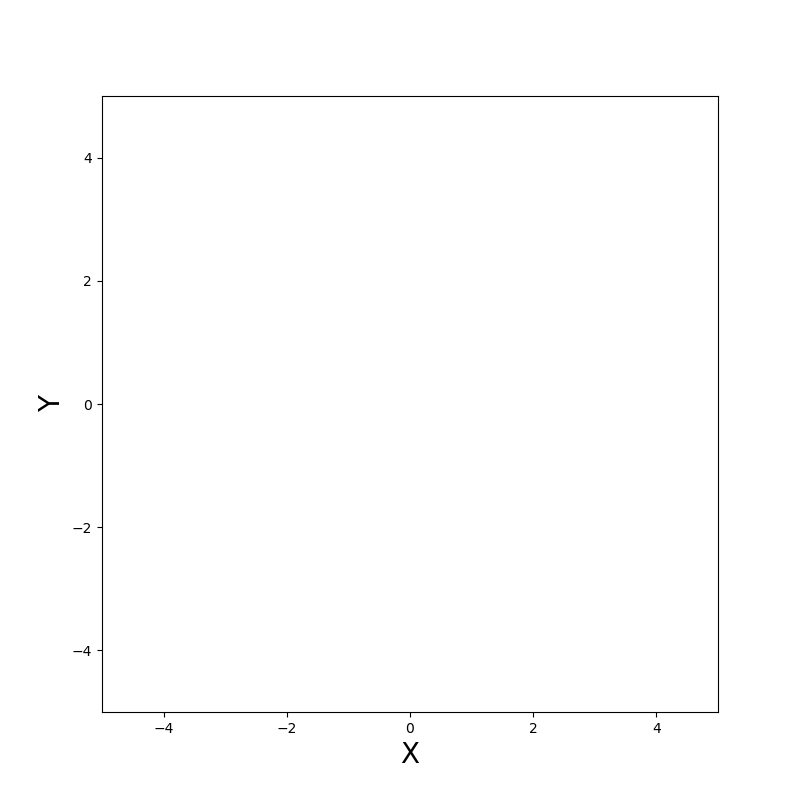

In [17]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30, time_interval, debug=False)

    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=None, agent=a, color="red")
    world.append(r)

    world.draw()

trial({"nn":1, "no":2, "on":3, "oo":4})